In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../../')

import read_trace
import cuda_timeline
from avgblkmodel import *
import cke
from df_util import *
#from model_cke import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [3]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

# 2 stream info

In [4]:
# 10M for mem_mem : where the h2d between streams are overlapped
trace_file = '1stream_23000.csv'
trace_file_2cke = '2stream_kern_ovlp_23000.csv'

df_trace = read_trace.trace2dataframe(trace_file) # read the trace to the dataframe
df_trace_2cke = read_trace.trace2dataframe(trace_file_2cke)

In [5]:
df_trace

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,KB,GB/s,NaN,NaN,NaN,NaN
1,588.507525,16.641000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.148830,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,588.525606,16.128000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.312604,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
3,588.708136,56.961000,90.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
4,588.770761,15.905000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.387091,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]


/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


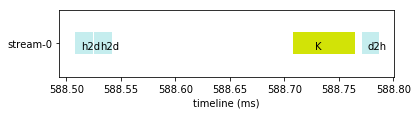

In [6]:
cuda_timeline.plot_trace(df_trace)

In [7]:
df_trace_2cke

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,KB,GB/s,NaN,NaN,NaN,NaN
1,806.383704,16.704000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.129411,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,806.401624,16.417000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.219082,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
3,806.419321,16.576000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.169020,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
4,806.437113,20.993000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,4.081440,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
5,806.716992,69.089000,90.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
6,806.755233,73.793000,90.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,14.0,"kernel_vectorAdd(float const *, float const *,..."
7,806.788705,15.937000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.376274,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]
8,806.832162,15.873000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.397951,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy DtoH]


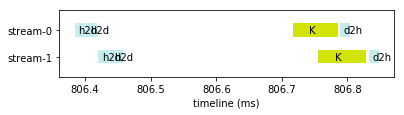

In [8]:
cuda_timeline.plot_trace(df_trace_2cke)

# 1cke - read trace and reset the timeline

In [9]:
df_single_stream = read_trace.get_timing(df_trace)

In [10]:
df_single_stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,588.507525,588.524166,89.84375,0.016641
1,0.0,h2d,588.525606,588.541734,89.84375,0.016128
2,0.0,kern,588.708136,588.765097,0.00000,0.056961
3,0.0,d2h,588.770761,588.786666,89.84375,0.015905


In [11]:
df_s1 = read_trace.reset_starting(df_single_stream)

In [12]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,0.016641,89.84375,0.016641
1,0.0,h2d,0.018081,0.034209,89.84375,0.016128
2,0.0,kern,0.200611,0.257572,0.00000,0.056961
3,0.0,d2h,0.263236,0.279141,89.84375,0.015905


In [13]:
tot_runtime = read_trace.getTotalRuntime(df_s1)
print tot_runtime

0.279141


### 2cke case

In [14]:
df_2stream = read_trace.get_timing(df_trace_2cke)

In [15]:
df_2stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,806.383704,806.400408,89.84375,0.016704
1,0.0,h2d,806.401624,806.418041,89.84375,0.016417
2,0.0,kern,806.716992,806.786081,0.00000,0.069089
3,0.0,d2h,806.788705,806.804642,89.84375,0.015937
4,1.0,h2d,806.419321,806.435897,89.84375,0.016576
5,1.0,h2d,806.437113,806.458106,89.84375,0.020993
6,1.0,kern,806.755233,806.829026,0.00000,0.073793
7,1.0,d2h,806.832162,806.848035,89.84375,0.015873


In [16]:
tot_runtime = read_trace.getTotalRuntime(df_2stream)
print tot_runtime

0.464331


# 2 cke

In [17]:
stream_num = 2

# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

In [18]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,0.016641,89.84375,0.016641
1,0,h2d,0.018081,0.034209,89.84375,0.016128
2,0,kern,0.200611,0.257572,0.00000,0.056961
3,0,d2h,0.263236,0.279141,89.84375,0.015905


In [19]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,0.036209,0.052850,89.84375,0.016641
1,1,h2d,0.054290,0.070418,89.84375,0.016128
2,1,kern,0.236820,0.293781,0.00000,0.056961
3,1,d2h,0.299445,0.315350,89.84375,0.015905


### sort

In [20]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [21]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,sleep,5398.939367,0.0,89.84375,0.0,0.0,0.0
1,0.018081,0.034209,h2d,89.84375,0.0,sleep,5570.669023,0.0,89.84375,0.0,0.0,0.0
4,0.036209,0.052850,h2d,89.84375,1.0,sleep,5398.939367,0.0,89.84375,0.0,0.0,0.0
5,0.054290,0.070418,h2d,89.84375,1.0,sleep,5570.669023,0.0,89.84375,0.0,0.0,0.0
2,0.200611,0.257572,kern,0.00000,0.0,sleep,0.000000,0.0,0.00000,0.0,0.0,0.0
6,0.236820,0.293781,kern,0.00000,1.0,sleep,0.000000,0.0,0.00000,0.0,0.0,0.0
3,0.263236,0.279141,d2h,89.84375,0.0,sleep,5648.773970,0.0,89.84375,0.0,0.0,0.0
7,0.299445,0.315350,d2h,89.84375,1.0,sleep,5648.773970,0.0,89.84375,0.0,0.0,0.0


In [22]:
#
# run above

### start algo

In [23]:
count = 0
break_count = 5

while not cke.AllDone(df_all_api):
    count = count + 1
    #-----------------------
    # pick two api to model 
    #-----------------------
    df_all_api, r1, r2 = cke.PickTwo(df_all_api)
    
#     if count == break_count: break

    #-----------------------
    # check the last api or not 
    #-----------------------
    last_api = False
    if r1 == None and r2 == None:
        last_api = True
        
    if last_api == True:                          # go directly updating the last wake api
        df_all_api = cke.UpdateStream_lastapi(df_all_api)
        break
    
    
    #-----------------------
    # move the current_pos to the starting of coming api r2, and update r1 status
    #-----------------------
    df_all_api = cke.StartNext_byType(df_all_api, [r1, r2])   
#     if count == break_count: break

    #-----------------------------
    # if one call is done, continue the next round
    #-----------------------------
    if cke.CheckRowDone(df_all_api, r1, r2):
        continue
        
#     if count == break_count: break
        
    #-----------------------------
    # when all calls are active
    #-----------------------------
    
    #-----------------------------
    # check whether the two calls are kerns, if yes
    #-----------------------------
    whichType = cke.CheckType(df_all_api, r1, r2) # check whether the same api
    if whichType == None:
        df_all_api = cke.Predict_noConflict(df_all_api, r1, r2)
    elif whichType in ['h2d', 'd2h']: # data transfer in the same direction
        df_all_api = cke.Predict_transferOvlp(df_all_api, r1, r2, ways = 2.0)
    else: # concurrent kernel: todo
        print('run cke model')
        cke.FindStreamAndKernID(df_all_api, r1)
    
    if count == break_count: break
        
        

    # check any of r1 and r2 has status done. if done, go to next 

    

#         if count == break_count:
#             break



#     if count == break_count:
#         break

    rangeT = cke.Get_pred_range(df_all_api)
#         print rangeT

#     if count == break_count:
#         break

    extra_conc = cke.Check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT

    if extra_conc == 0:
        if whichType in ['h2d', 'd2h']:
            df_all_api = cke.Update_wake_transferOvlp(df_all_api, rangeT, ways = 2.0)
        elif whichType == 'kern':
            pass
        else: # no overlapping
            df_all_api = cke.Update_wake_noConflict(df_all_api, rangeT)

        # check if any api is done, and update the timing for the other apis in that stream
        df_all_api = cke.UpdateStreamTime(df_all_api)

    else: # todo : when there is additional overlapping
        pass

#         if count == break_count:
#             break
        


row:0 row:1
row:1 row:4
row:4 row:5
row:5 row:2
row:2 row:6
run cke model


In [24]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,done,5398.939367,89.84375,0.00000,0.016641,0.0,0.0
1,0.018081,0.034209,h2d,89.84375,0.0,done,5570.669023,89.84375,0.00000,0.034209,0.0,0.0
4,0.036209,0.052850,h2d,89.84375,1.0,done,5398.939367,89.84375,0.00000,0.052850,0.0,0.0
5,0.054290,0.070418,h2d,89.84375,1.0,done,5570.669023,89.84375,0.00000,0.070418,0.0,0.0
2,0.200611,0.257572,kern,0.00000,0.0,wake,0.000000,0.00000,0.00000,0.236820,0.0,0.0
6,0.236820,0.293781,kern,0.00000,1.0,wake,0.000000,0.00000,0.00000,0.236820,0.0,0.0
3,0.263236,0.279141,d2h,89.84375,0.0,sleep,5648.773970,0.00000,89.84375,0.000000,0.0,0.0
7,0.299445,0.315350,d2h,89.84375,1.0,sleep,5648.773970,0.00000,89.84375,0.000000,0.0,0.0


In [25]:
df_all_api.loc[df_all_api.stream_id == 0]

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,done,5398.939367,89.84375,0.00000,0.016641,0.0,0.0
1,0.018081,0.034209,h2d,89.84375,0.0,done,5570.669023,89.84375,0.00000,0.034209,0.0,0.0
2,0.200611,0.257572,kern,0.00000,0.0,wake,0.000000,0.00000,0.00000,0.236820,0.0,0.0
3,0.263236,0.279141,d2h,89.84375,0.0,sleep,5648.773970,0.00000,89.84375,0.000000,0.0,0.0


In [26]:
df_all_api.loc[df_all_api.stream_id == 1]

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
4,0.036209,0.052850,h2d,89.84375,1.0,done,5398.939367,89.84375,0.00000,0.052850,0.0,0.0
5,0.054290,0.070418,h2d,89.84375,1.0,done,5570.669023,89.84375,0.00000,0.070418,0.0,0.0
6,0.236820,0.293781,kern,0.00000,1.0,wake,0.000000,0.00000,0.00000,0.236820,0.0,0.0
7,0.299445,0.315350,d2h,89.84375,1.0,sleep,5648.773970,0.00000,89.84375,0.000000,0.0,0.0


In [27]:
#
# run above
#